In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import torch
import torch.nn as nn
import torch.optim as optim
import os

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18,googlenet, densenet121,mobilenet_v3_small,mobilenet_v3_large
from sklearn.model_selection import train_test_split
from PIL import Image


In [3]:

def multiple_dir_files_to_df(dirs, label):
    df = pd.DataFrame()
    for idx,dir in enumerate(dirs):
        files = os.listdir(dir)
        files = [dir + '/' + file for file in files]
        df = pd.concat([df,pd.DataFrame({'file': files, 'label': label[idx]})])
    return df

df_au = pd.read_csv(f"../AU_models/dataset/Database.csv")

labels=["neutral","happy","sad","fear","angry","surprise","disgust"]
full_labels =["neutral","happy","sad","fear","angry","surprise","disgust","Happily_Surprised",
"Happily_Disgusted","Sadly_Fearful","Sadly_Angry","Sadly_Surprised","Sadly_Disgusted",
"Fearfully_Angry","Fearfully_Surprised","Fearfully_Disgusted","Angrily_Surprised",
"Angrily_Disgusted","Disgustedly_Surprised","Appalled","Hatred","Awed"]

# database=[common_path+label for label in labels]
# database_full=[common_path+label for label in full_labels]

def training_test_model(train_loader, val_loader, test_loader, model,model_name,epochs=50, learning_rate=0.001,weight_decay=1e-4,gamma=0.9,early_stopping_patience=5,early_stopping_save=True):
    # Initialiser le modèle et le journal
    model = model
    patience = early_stopping_patience
    best_val_loss = float('inf')
    counter = 0
    accuracy_val_list=[]
    accuracy_train_list=[]
    loss_val_list=[]
    loss_train_list=[]
    
    # Entraîner le modèle
    num_epochs = epochs
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Définir l'optimiseur et la fonction de perte
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=gamma)
    # Entraîner le modèle
    for epoch in range(num_epochs):
        accuracy_train=[]
        loss_train=[]
        accuracy_val=[]
        loss_val=[]
        accuracy_test=[]
        loss_test=[]
        current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]

        model.train()
        for batch_idx, (data, targets, _) in enumerate(train_loader):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets.long())

            # backward
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            likelihood, predictions = scores.max(1)
            loss_train.append(loss.item())
            accuracy_train.append((predictions == targets).float().mean().item())

            # gradient descent or adam step
        scheduler.step()

        model.eval()
        for batch_idx, (data, targets, _) in enumerate(val_loader):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets.long())
            
            likelihood, predictions = scores.max(1)
            loss_val.append(loss.item())
            accuracy_val.append((predictions == targets).float().mean().item())

        #testing the model
        for batch_idx, (data, targets, _)  in enumerate(test_loader):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets.long())
            
            likelihood, predictions = scores.max(1)
            loss_test.append(loss.item())
            accuracy_test.append((predictions == targets).float().mean().item())

        accuracy_train=np.array(accuracy_train).mean()
        loss_train=np.array(loss_train).mean()
        accuracy_val=np.array(accuracy_val).mean()
        loss_val=np.array(loss_val).mean()
        accuracy_test=np.array(accuracy_test).mean()
        loss_test=np.array(loss_test).mean()
        accuracy_val_list.append(accuracy_val)
        accuracy_train_list.append(accuracy_train)
        loss_val_list.append(loss_val)
        loss_train_list.append(loss_train)
        
        if early_stopping_save:
            if loss_val < best_val_loss:
                best_val_loss = loss_val
                best_val_accuracy = accuracy_val
                counter = 0
                best_params = model.state_dict()
            else:
                counter += 1
            if counter > patience:
                print("Early stopping at epoch: ",epoch)
                print("Saving model...")
                saved_params = model.state_dict()
                # get percentage of accuracy
                best_val_accuracy = np.round(best_val_accuracy*100,0)
                torch.save(saved_params, f"./models_tg/{model_name}_{str(int(best_val_accuracy))}.pth")
                return accuracy_val_list,accuracy_train_list,loss_val_list,loss_train_list
        print(f"Train epoch: {epoch}, accuracy = {accuracy_train} ,loss = {loss_train}, lr = {np.round(current_lr,6)}")
        print(f"val epoch: {epoch}, accuracy = {accuracy_val} ,loss = {loss_val}")
        print(f"test epoch: {epoch}, accuracy = {accuracy_test} ,loss = {loss_test}")

    
    torch.save(model.state_dict(), f"./models/{model_name}.pth")
    return accuracy_val_list,accuracy_train_list,loss_val_list,loss_train_list

def plot_train_loss(accuracy_test_list,accuracy_train_list,loss_test_list,loss_train_list,model_name):
    plt.figure(figsize=(10,5))
    plt.plot(accuracy_test_list,label="accuracy_test")
    plt.plot(accuracy_train_list,label="accuracy_train")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy for "+model_name+" model")
    plt.legend()
    plt.figure(figsize=(10,5))
    plt.plot(loss_test_list,label="loss_test")
    plt.plot(loss_train_list,label="loss_train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss for "+model_name+" model")
    plt.legend()


# df = multiple_dir_files_to_df(database,np.linspace(0,6,7))
# X,y=df["file"].tolist(),df["label"].tolist()

# #Split the dataset into train and test
# df_full = multiple_dir_files_to_df(database_full,np.linspace(0,21,22))

df_full = pd.read_csv(f"database_train.csv")


X_full= ["database_train/" + s for s in df_full["filenames"].values]
y_full= [int(i.split("_")[0]) -1 for i in df_full["filenames"].values]





#get data with labels
X_train = [X_full[i] for i in range(len(X_full)) if int(y_full[i]) < 7]
y_train = [y_full[i] for i in range(len(y_full)) if int(y_full[i]) < 7]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

print("Train head: ",X_train[:5],"\n",y_train[:5])
print("Test head: ",X_val[:5],"\n",y_val[:5])

# Définir un Dataset personnalisé
# Définir un Dataset personnalisé
class CustomDataset(Dataset):
    def __init__(self, file_names, labels,  transform=None):
        self.file_names = file_names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_path = f'{self.file_names[idx]}' 
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        image, label = image.to(device), label.to(device)

        return image, label, self.file_names[idx]

# Define the image transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])
# Créer les jeux de données et les chargeurs de données
train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
val_dataset = CustomDataset(X_val, y_val, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


class MobileNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobilenet = mobilenet_v3_small(weights='IMAGENET1K_V1')
        self.mobilenet.classifier[3] = nn.Linear(1024, 7)
    def forward(self, x):
        return self.mobilenet(x)

Train head:  ['database_train/05_150.jpg', 'database_train/05_070.jpg', 'database_train/06_006.jpg', 'database_train/04_097.jpg', 'database_train/04_173.jpg'] 
 [4, 4, 5, 3, 3]
Test head:  ['database_train/01_166.jpg', 'database_train/05_174.jpg', 'database_train/01_118.jpg', 'database_train/01_225.jpg', 'database_train/07_201.jpg'] 
 [0, 4, 0, 0, 6]


In [4]:
#get number of values for each label
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 163, 1: 163, 2: 162, 3: 167, 4: 171, 5: 164, 6: 161}


In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

In [60]:
training_df

,filenames,labels
0,22_199.jpg,Awed
1,04_199.jpg,fear
2,22_169.jpg,Awed
3,05_193.jpg,angry
4,21_215.jpg,Hatred
...,...,...
4549,11_088.jpg,Sadly_Angry
4550,20_206.jpg,Appalled
4551,11_156.jpg,Sadly_Angry
4552,16_134.jpg,Fearfully_Disgusted


In [6]:
training_df  = pd.read_csv("database_train.csv")

training_basic_df = training_df[training_df["labels"].isin(labels)]



X_train, X_val, y_train, y_val = train_test_split(training_basic_df["filenames"].tolist(), training_basic_df["labels"].tolist(), test_size=0.2, stratify=training_basic_df["labels"].tolist())

X_train = ["database_train/" + s for s in X_train]
X_val = ["database_train/" + s for s in X_val]

y_train = [labels.index(i) for i in y_train]
y_val = [labels.index(i) for i in y_val]

train_loader = DataLoader(CustomDataset(X_train, y_train, transform=train_transform), batch_size=32, shuffle=True)
val_loader = DataLoader(CustomDataset(X_val, y_val, transform=train_transform), batch_size=32, shuffle=False)

In [7]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [8]:
df_test = pd.read_csv(f"database_test.csv")


X_test_full= ["database_test/" + s for s in df_test["filenames"].values]
y_test_full= [int(i.split("_")[0]) -1 for i in df_test["filenames"].values]



#get data with labels
X_test = [X_test_full[i] for i in range(len(X_test_full)) if int(y_test_full[i]) < 7]
y_test = [y_test_full[i] for i in range(len(y_test_full)) if int(y_test_full[i]) < 7]

test_loader = DataLoader(CustomDataset(X_test, y_test, transform=test_transform), batch_size=32, shuffle=False)

Train epoch: 0, accuracy = 0.48503861072901133 ,loss = 1.3248868810163963, lr = 0.001
val epoch: 0, accuracy = 0.4 ,loss = 1.4918916702270508
test epoch: 0, accuracy = 0.3645833333333333 ,loss = 1.4955202142397563
Train epoch: 1, accuracy = 0.7422779927382598 ,loss = 0.6768224956216039, lr = 0.0009
val epoch: 1, accuracy = 0.259375 ,loss = 2.7695318460464478
test epoch: 1, accuracy = 0.22916666666666666 ,loss = 2.2635767459869385
Train epoch: 2, accuracy = 0.810690154900422 ,loss = 0.5131768930602718, lr = 0.00081
val epoch: 2, accuracy = 0.33125 ,loss = 2.246168923377991
test epoch: 2, accuracy = 0.20833333333333334 ,loss = 2.598451336224874
Train epoch: 3, accuracy = 0.8313223945127951 ,loss = 0.44109671603183487, lr = 0.000729
val epoch: 3, accuracy = 0.403125 ,loss = 1.7908560514450074
test epoch: 3, accuracy = 0.453125 ,loss = 1.732222080230713
Train epoch: 4, accuracy = 0.8431467188371194 ,loss = 0.41082107678458496, lr = 0.000656
val epoch: 4, accuracy = 0.628125 ,loss = 1.13446

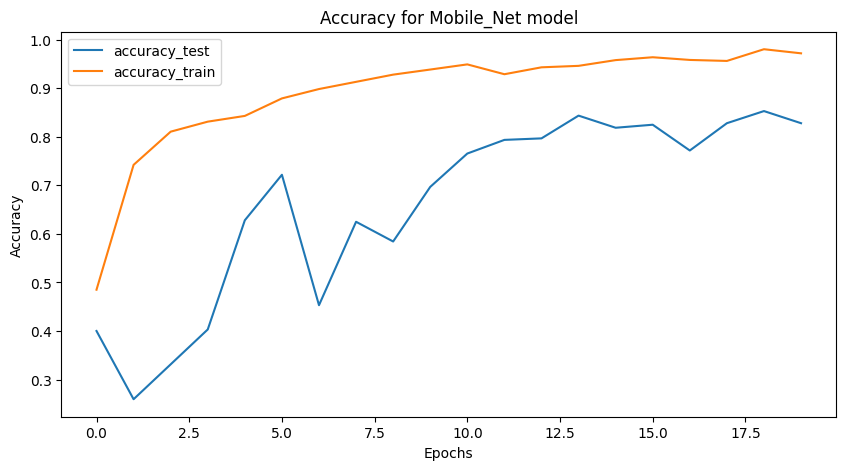

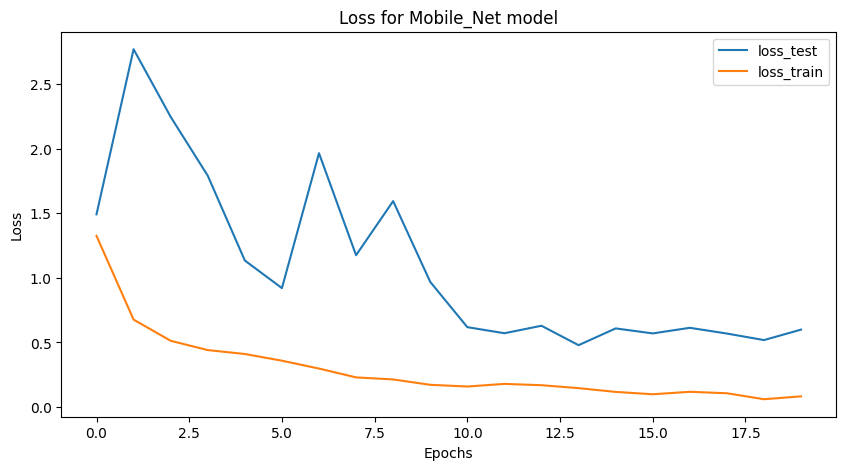

In [136]:
model=MobileNet()
accuracy_val_list,accuracy_train_list,loss_val_list,loss_train_list=training_test_model(train_loader,val_loader, test_loader,model,"MobileNet",epochs=50, learning_rate=0.001,weight_decay=1e-4,gamma=0.9,early_stopping_patience=5,early_stopping_save=True)
plot_train_loss(accuracy_val_list,accuracy_train_list,loss_val_list,loss_train_list,"Mobile_Net")


In [9]:
au_df = pd.read_csv(f"action_units.csv")


FileNotFoundError: [Errno 2] No such file or directory: 'action_units.csv'

In [81]:
au_df

,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,filename
0,0.00,0.00,0.28,0.00,0.31,1.19,0.0,0.26,0.10,0.00,0.71,0.89,0.00,0.00,0.00,0.82,0.00,22_199.jpg
1,0.73,0.22,0.55,0.00,0.36,0.68,0.0,0.89,0.39,0.05,0.46,1.47,0.00,0.00,0.56,1.04,0.17,04_199.jpg
2,0.66,0.22,1.48,0.00,0.45,0.44,0.0,0.81,0.36,0.07,0.22,2.36,0.11,0.51,0.56,1.25,0.87,22_169.jpg
3,0.25,0.00,1.52,0.00,0.35,0.24,0.0,0.33,0.19,0.07,0.60,2.14,0.11,0.51,0.42,0.84,0.87,05_193.jpg
4,0.00,0.00,1.71,0.00,0.24,0.31,0.0,0.36,0.25,0.02,0.38,1.89,0.11,0.51,0.05,0.58,0.69,21_215.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5055,1.49,1.12,1.18,0.69,0.00,0.26,0.0,0.34,0.10,0.05,0.00,0.23,0.05,0.33,1.52,2.55,0.14,NaN
5056,1.47,0.00,1.05,0.20,0.09,0.38,0.0,0.84,0.49,0.05,0.34,0.23,0.13,0.33,1.87,1.92,0.00,NaN
5057,1.06,0.00,1.01,0.71,0.09,0.38,0.0,0.92,0.49,0.05,0.34,0.43,0.08,0.10,2.21,1.64,0.00,NaN
5058,2.01,1.07,0.56,0.51,0.14,0.38,0.0,0.62,0.51,0.00,0.34,0.34,0.19,0.05,2.39,1.01,0.05,NaN


In [96]:
set(y_test_full)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}

In [10]:
# Créer les jeux de données et les chargeurs de données
t_dataset = CustomDataset(X_test_full, y_test_full,  test_transform)
t_loader = DataLoader(t_dataset, batch_size=10, shuffle=False)

In [11]:
training_df  = pd.read_csv("database_train.csv")



X_train = ["database_train/" + s for s in training_df["filenames"].tolist()]

y_train = [full_labels.index(i) for i in training_df["labels"].tolist()]

train_loader = DataLoader(CustomDataset(X_train, y_train, transform=test_transform), batch_size=32, shuffle=True)

In [12]:
testing_df  = pd.read_csv("database_test.csv")



X_test = ["database_test/" + s for s in testing_df["filenames"].tolist()]

y_test = [full_labels.index(i) for i in testing_df["labels"].tolist()]

test_loader = DataLoader(CustomDataset(X_test, y_test, transform=test_transform), batch_size=32, shuffle=True)

In [17]:
df_aug = pd.read_csv("database_aug.csv")

In [18]:
df_aug["filenames"].values

array(['07_110_eguwgohbvk.jpg', '02_098_bfqxkcvacg.jpg',
       '11_112_hyjriqbzlf.jpg', ..., '06_093_cnxmgikbrt.jpg',
       '19_032_lkbiiqbqsz.jpg', '11_216_appvikpxyu.jpg'], dtype=object)

In [19]:
files = df_aug["filenames"].values
r  =[]
for f in files:
    r.append(f[:6] + "_" + f[6:])

df_aug["filenames"] = r


In [14]:
df_aug.to_csv("database_aug.csv")

NameError: name 'df_aug' is not defined

In [23]:
aug_loader = DataLoader(CustomDataset(["database_aug/" + s for s in df_aug["filenames"].tolist()], [full_labels.index(i) for i in df_aug["labels"].tolist()], transform=test_transform), batch_size=32, shuffle=True)

In [20]:
class Feature_Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobilenet = mobilenet_v3_small(weights='IMAGENET1K_V1')
        self.mobilenet.classifier = nn.Identity()

    def forward(self, x):
        return self.mobilenet(x)
        


In [21]:
pretrained_model =rf"models_tg/MobileNet_0_0.pth"
model = Feature_Extractor()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(pretrained_model, map_location=device), strict=False)
model.to(device)
model.eval()
df=pd.DataFrame()

name_list = []
for i, (x, y, names) in enumerate(aug_loader):
    x = x.to(device)
    y = y.to(device)
    name_list = np.concatenate([name_list,names])
    with torch.no_grad():
        output = model(x)
        df=pd.concat([df,pd.DataFrame(output.cpu().numpy())])

In [162]:
name_list = np.array(name_list)

In [163]:
name_list = np.array([name.split("/")[-1] for name in name_list])

In [164]:
len(name_list)

506

In [165]:
#join au and df by filename
au_df = pd.read_csv(f"action_units.csv")
df["filenames"] = name_list
df = df.join(au_df.set_index("filenames"), on="filenames")

In [108]:
df["file"]  = [s.split("_")[0] + "_" + s.split("_")[1]  + ".jpg" for s in df["filenames"]]

In [109]:
au_df["file"] = au_df["filenames"]

In [167]:
df["filenames"]

0     22_005.jpg
1     21_104.jpg
2     22_163.jpg
3     09_194.jpg
4     19_181.jpg
         ...    
21    19_227.jpg
22    16_220.jpg
23    07_164.jpg
24    22_001.jpg
25    12_166.jpg
Name: filenames, Length: 506, dtype: object

In [110]:
au_df = au_df.drop(columns=["filenames"])

In [111]:
df

,0,1,2,3,4,5,6,7,8,9,...,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,file
0,-0.175165,-0.062648,0.146258,-0.088492,-0.007345,0.091092,0.197360,0.574965,0.058800,0.085182,...,0.00,0.00,0.15,1.00,0.00,0.00,2.47,2.66,0.40,17_141.jpg.jpg
1,0.024557,0.108385,0.284570,-0.053635,0.093264,0.656621,1.284849,-0.144660,0.007041,-0.027862,...,2.95,1.78,0.00,0.39,0.16,0.01,2.08,0.08,0.40,09_021.jpg.jpg
2,-0.028487,0.493023,0.076103,-0.131347,0.692240,0.265297,0.160759,0.549660,0.020944,-0.139823,...,0.05,0.31,0.00,1.19,0.00,0.81,1.33,0.73,0.27,12_124.jpg.jpg
3,-0.083434,0.237266,-0.149829,0.358560,0.282838,-0.081927,0.940098,-0.026410,0.080800,-0.110453,...,0.62,0.48,0.34,2.86,0.00,0.78,0.41,0.18,0.04,19_051.jpg.jpg
4,-0.178832,-0.197923,1.366877,-0.004156,0.228082,0.163298,0.849737,0.248175,0.052518,0.892593,...,0.31,0.10,0.22,1.98,0.00,0.46,0.49,0.00,0.42,18_150.jpg.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,0.092986,1.004637,0.299254,-0.188847,0.203807,0.822136,0.424867,0.721606,0.322522,-0.028987,...,0.91,0.60,0.18,0.00,0.58,0.00,2.18,0.38,0.00,04_076.jpg.jpg
22,0.031066,0.205892,-0.030964,-0.031365,-0.014612,0.027920,0.331226,-0.021185,-0.053156,0.211413,...,0.13,0.16,0.05,0.91,0.00,0.68,0.85,2.99,0.26,06_195.jpg.jpg
23,-0.147237,-0.117121,0.320282,0.158241,-0.202569,0.005255,0.907753,-0.108088,-0.014011,-0.154053,...,2.62,1.85,0.00,0.22,0.65,0.53,2.47,0.31,0.67,09_047.jpg.jpg
24,0.241011,0.637997,0.217825,-0.155309,0.124912,0.692785,0.418828,0.687541,0.336979,0.054476,...,0.15,0.13,0.00,0.00,0.11,0.10,2.14,1.54,0.16,10_158.jpg.jpg


In [112]:
#remove columns containing AU

df = df.drop(columns=au_df.drop(columns=["filenames"]).columns)


KeyError: "['filenames'] not found in axis"

In [90]:
df = df.drop(columns=["file"])

In [168]:
#make the column filenames the first column
df = df[ ['filenames'] + [ col for col in df.columns if col != 'filenames' ] ]

In [152]:
df

,filenames,0,1,2,3,4,5,6,7,8,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
0,09_115.jpg,-0.118220,0.373478,0.335585,-0.104677,0.442772,0.085678,1.184191,0.127086,-0.115152,...,2.81,3.56,1.98,0.00,0.03,0.02,0.39,3.67,0.85,1.07
1,14_079.jpg,0.029183,0.246188,0.550210,-0.067341,-0.019468,0.510155,0.917282,0.029054,0.247781,...,1.69,0.83,0.73,0.12,0.62,0.62,0.00,2.89,0.13,0.00
2,14_048.jpg,0.716629,0.517522,0.103762,0.127723,0.809337,0.632867,0.736483,1.214108,0.306316,...,1.10,1.34,1.12,0.05,0.42,1.06,0.74,2.07,1.08,0.00
3,22_064.jpg,0.560288,0.159442,0.065034,0.357631,-0.219589,0.750378,0.008544,0.468055,0.549397,...,0.22,0.00,0.00,0.58,0.95,0.08,0.00,1.18,2.33,0.20
4,15_057.jpg,0.491213,-0.018625,-0.044381,0.485006,-0.105647,0.795110,0.056377,0.672013,0.139209,...,0.69,0.29,0.00,0.13,0.28,0.00,0.00,2.99,2.09,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,01_226.jpg,0.605760,0.427991,-0.156582,0.394175,-0.129037,-0.017992,0.033350,0.204412,0.191457,...,1.38,0.29,0.35,1.66,0.70,0.22,0.00,2.58,0.03,0.29
6,09_015.jpg,0.066992,0.268660,0.245865,-0.088991,-0.176313,0.631403,1.300467,-0.055730,-0.081289,...,2.15,2.17,0.94,0.13,0.10,0.49,0.46,2.91,0.43,0.59
7,06_028.jpg,0.158757,0.714599,0.028517,0.156374,-0.065457,0.390565,-0.008125,0.273807,0.172923,...,0.00,0.03,0.00,0.00,0.81,0.00,0.20,1.23,3.63,0.16
8,12_009.jpg,0.260709,0.505919,0.068758,-0.094321,0.866763,0.544919,-0.006386,0.542581,0.311012,...,1.26,0.69,0.16,2.79,0.62,0.40,0.00,2.51,0.64,0.00


In [169]:
#remove the filenames
df.to_csv("test_features.csv", index=False)

In [121]:
df = pd.read_csv("test_features.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'test_features.csv'

Index(['filenames', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '566', '567', '568', '569', '570', '571', '572', '573', '574', '575'],
      dtype='object', length=577)

In [211]:
#join au and df by filename
au_df = pd.read_csv(f"action_units.csv")
df = df.join(au_df.set_index("filenames"), on="filenames")

In [213]:
df

,filenames,0,1,2,3,4,5,6,7,8,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
0,14_145.jpg,-0.146227,1.049174,0.612587,-0.234947,1.398475,0.124121,0.331639,0.890943,1.504977,...,1.59,0.91,0.63,0.00,0.03,0.58,0.07,2.47,0.23,0.00
1,22_060.jpg,0.841822,0.314215,0.028069,0.005219,0.066893,0.380032,0.562355,0.114429,0.319535,...,0.39,0.38,0.00,0.70,0.72,0.44,0.00,2.06,2.32,0.05
2,19_164.jpg,-0.096300,-0.048862,0.244150,0.018696,0.136126,0.289470,0.486330,0.330084,0.508849,...,0.70,0.27,0.37,1.66,3.02,0.01,0.00,0.00,0.41,0.00
3,15_173.jpg,0.463471,0.390771,-0.042587,0.670090,-0.077890,0.360066,1.174203,0.150124,-0.073686,...,0.98,0.90,0.00,0.14,0.80,0.08,0.00,1.73,2.63,0.13
4,16_099.jpg,0.673938,0.201442,-0.185028,0.501732,-0.185247,0.963540,1.005714,0.519300,-0.200629,...,1.18,1.12,0.81,0.39,0.35,0.48,0.00,1.83,0.06,0.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,05_125.jpg,-0.176250,0.377597,0.600394,-0.167403,1.060377,0.314700,0.727762,0.904458,0.423733,...,2.43,0.42,1.27,0.57,3.75,0.58,1.45,0.22,0.00,0.86
502,21_048.jpg,0.085320,0.198965,-0.068312,0.123255,0.215149,-0.056790,0.762385,0.358502,0.207337,...,0.51,0.00,0.00,0.18,1.32,0.75,0.35,0.14,0.90,0.32
503,18_212.jpg,-0.140799,0.261438,0.079792,-0.189337,1.110367,0.049297,0.601979,1.091359,1.567930,...,1.46,0.37,0.48,0.36,2.60,0.28,0.13,0.87,0.96,0.00
504,11_062.jpg,0.173838,0.122495,-0.070115,-0.177105,0.852050,0.519580,0.665718,1.027823,0.615280,...,1.01,0.00,0.43,1.37,1.75,1.08,0.78,0.53,0.85,0.41


In [209]:
df = df.drop(columns=["Unnamed: 0"])

In [202]:
df

,filenames,0,1,2,3,4,5,6,7,8,...,566,567,568,569,570,571,572,573,574,575
0,16_157.jpg,-0.288144,-0.093708,0.530758,0.757584,0.363100,1.334005,0.840161,0.835225,-0.082017,...,-0.044054,0.317633,0.578489,0.412853,0.619072,0.190825,-0.024230,0.485484,0.426587,0.631932
1,15_062.jpg,1.039082,0.476410,-0.008762,0.073809,0.156677,0.282160,0.948805,0.792385,0.434160,...,0.306964,0.383786,0.653881,0.478839,0.737291,-0.173985,0.365891,0.496888,-0.037716,0.421044
2,22_095.jpg,0.496613,0.743648,0.363337,0.892317,0.195693,0.224687,0.573656,0.511187,0.462886,...,0.203468,0.169767,-0.162686,0.372255,0.495087,-0.038814,0.345075,0.813733,0.175408,0.474662
3,14_148.jpg,0.557365,0.807790,0.292238,0.019484,0.527813,1.009287,0.823071,0.917766,1.177440,...,0.286165,0.439054,0.811104,0.195692,0.306481,0.566558,1.368218,0.635832,0.328005,0.761365
4,18_061.jpg,-0.125715,-0.126593,0.222445,0.036855,0.364139,0.959774,0.341768,0.844662,0.215528,...,0.052703,0.162462,0.291755,0.002313,0.368004,0.438411,-0.007894,-0.079526,0.156452,0.195014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4549,16_168.jpg,0.518486,0.751002,-0.137514,0.289951,0.473506,0.697474,0.859269,0.861493,0.682721,...,0.282681,0.603515,0.757778,0.036156,0.288797,-0.094509,0.570984,0.493484,0.220362,0.424641
4550,13_004.jpg,-0.010945,-0.145591,0.466774,0.301659,0.544389,1.411061,0.512935,1.134108,0.359995,...,0.014230,0.295177,0.167719,0.330392,0.530559,0.253628,-0.017504,0.564067,0.280524,1.107663
4551,10_214.jpg,0.403370,0.870930,-0.063292,0.177560,0.547126,0.251215,0.134116,0.609173,0.549132,...,0.362046,0.705169,0.232845,0.392430,0.269916,0.006546,0.615186,0.310130,0.097619,-0.104990
4552,19_076.jpg,0.034412,0.116860,0.289996,-0.165717,0.184604,0.541893,1.632988,1.063915,-0.102401,...,-0.126492,0.125598,0.009109,0.043185,0.354240,-0.123373,0.348300,0.551057,0.930158,0.772210


In [127]:
au_df = pd.read_csv("../AU_models/dataset/partial_database.csv")

In [131]:
au_df["filename"] = X_full

In [135]:
au_test = au_df[au_df["filename"].isin(X_test_full)]

In [136]:
au_test

,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,filename
8,0.09,0.00,0.55,0.00,0.00,0.00,0.00,0.23,0.00,0.00,0.26,0.49,0.00,0.00,0.00,0.26,0.39,Image/neutral/01_009.jpg
12,0.73,0.49,0.25,0.00,0.36,0.00,0.00,0.22,0.47,0.21,0.00,0.44,0.18,0.55,0.20,0.61,0.18,Image/neutral/01_013.jpg
23,0.00,0.00,0.73,0.00,0.46,0.04,0.00,0.40,0.39,1.08,0.63,0.56,0.43,0.73,0.01,0.35,0.37,Image/neutral/01_024.jpg
26,0.00,0.02,0.66,0.00,0.15,0.04,0.54,0.05,0.08,0.12,0.80,1.46,0.34,0.29,0.00,0.18,0.08,Image/neutral/01_027.jpg
29,0.52,0.22,0.34,0.04,0.12,0.05,0.00,0.36,0.23,0.02,0.72,1.71,0.39,0.55,0.00,0.85,0.40,Image/neutral/01_030.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978,0.80,0.41,0.27,0.24,0.00,0.14,0.00,0.29,0.00,0.00,0.16,0.47,0.00,0.00,1.99,2.80,0.22,Image/Awed/22_149.jpg
5002,1.22,0.35,0.90,0.00,0.71,1.10,0.00,0.83,0.93,0.14,0.13,1.29,0.02,0.00,1.18,2.96,0.00,Image/Awed/22_173.jpg
5026,1.10,0.87,0.79,0.69,0.00,0.36,0.00,0.65,0.19,0.00,0.45,1.13,0.06,0.09,2.13,2.89,0.21,Image/Awed/22_197.jpg
5048,1.80,0.47,0.60,0.78,0.08,0.70,0.00,0.47,0.41,0.00,0.16,0.94,0.00,0.00,1.89,2.52,0.00,Image/Awed/22_219.jpg


In [137]:
df

,0,1,2,3,4,5,6,7,8,9,...,566,567,568,569,570,571,572,573,574,575
0,0.296105,0.491917,1.017336,0.038660,0.782699,0.318266,0.655325,0.937156,0.307206,0.222212,...,0.190083,0.190133,0.188924,0.404477,0.639926,0.772853,0.222845,0.149794,0.094883,-0.074156
1,0.372549,-0.223970,-0.214214,0.590657,0.685903,0.397092,1.554108,0.492586,0.102385,-0.112660,...,-0.021888,-0.204899,0.135100,1.151574,0.022930,1.026442,-0.044748,0.030253,0.265468,0.351452
2,0.368130,0.190689,0.989962,0.086350,0.724702,0.347256,0.416901,0.403468,0.083517,0.706257,...,0.125957,-0.048460,0.161734,0.575226,0.465520,-0.017434,0.072976,0.711666,0.128095,-0.039858
3,0.459799,0.080641,0.176306,0.473327,0.087260,0.483808,0.181613,0.227034,0.861669,-0.111733,...,1.143454,0.669014,0.998945,0.009127,0.356825,-0.156882,0.449426,0.685110,0.258853,-0.078747
4,0.687890,0.253551,1.582253,-0.006660,0.919078,0.901663,0.257715,0.739861,0.226957,0.963657,...,0.133991,0.566608,0.240382,0.578626,0.859630,0.364643,-0.137230,0.799791,0.292136,-0.164194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.301494,0.504506,-0.157817,0.640859,0.064805,0.262169,0.619396,0.295381,0.300928,0.597042,...,0.365986,-0.091253,1.193101,0.158918,0.218488,0.111179,1.170864,0.021165,0.213411,0.245635
2,0.463454,0.499345,-0.160016,-0.015046,-0.054237,0.422948,0.276226,0.013242,1.140800,0.545551,...,0.624549,0.826386,1.128712,-0.053121,0.139199,0.079066,0.762737,0.565546,-0.008224,-0.083190
3,-0.159608,0.779548,0.965291,0.594863,0.664449,0.519327,0.281538,0.133355,0.786948,-0.018260,...,-0.098489,0.243071,-0.090838,0.365060,0.578444,-0.086677,0.308268,0.083896,0.484199,0.827001
4,0.712951,0.385979,0.088335,-0.041925,0.060440,1.321188,0.011487,0.098310,0.698674,0.855466,...,0.270109,0.277489,0.690173,0.397199,0.294358,0.565407,0.030327,0.738168,0.046604,-0.108994


In [138]:
df

,0,1,2,3,4,5,6,7,8,9,...,566,567,568,569,570,571,572,573,574,575
0,0.296105,0.491917,1.017336,0.038660,0.782699,0.318266,0.655325,0.937156,0.307206,0.222212,...,0.190083,0.190133,0.188924,0.404477,0.639926,0.772853,0.222845,0.149794,0.094883,-0.074156
1,0.372549,-0.223970,-0.214214,0.590657,0.685903,0.397092,1.554108,0.492586,0.102385,-0.112660,...,-0.021888,-0.204899,0.135100,1.151574,0.022930,1.026442,-0.044748,0.030253,0.265468,0.351452
2,0.368130,0.190689,0.989962,0.086350,0.724702,0.347256,0.416901,0.403468,0.083517,0.706257,...,0.125957,-0.048460,0.161734,0.575226,0.465520,-0.017434,0.072976,0.711666,0.128095,-0.039858
3,0.459799,0.080641,0.176306,0.473327,0.087260,0.483808,0.181613,0.227034,0.861669,-0.111733,...,1.143454,0.669014,0.998945,0.009127,0.356825,-0.156882,0.449426,0.685110,0.258853,-0.078747
4,0.687890,0.253551,1.582253,-0.006660,0.919078,0.901663,0.257715,0.739861,0.226957,0.963657,...,0.133991,0.566608,0.240382,0.578626,0.859630,0.364643,-0.137230,0.799791,0.292136,-0.164194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.301494,0.504506,-0.157817,0.640859,0.064805,0.262169,0.619396,0.295381,0.300928,0.597042,...,0.365986,-0.091253,1.193101,0.158918,0.218488,0.111179,1.170864,0.021165,0.213411,0.245635
2,0.463454,0.499345,-0.160016,-0.015046,-0.054237,0.422948,0.276226,0.013242,1.140800,0.545551,...,0.624549,0.826386,1.128712,-0.053121,0.139199,0.079066,0.762737,0.565546,-0.008224,-0.083190
3,-0.159608,0.779548,0.965291,0.594863,0.664449,0.519327,0.281538,0.133355,0.786948,-0.018260,...,-0.098489,0.243071,-0.090838,0.365060,0.578444,-0.086677,0.308268,0.083896,0.484199,0.827001
4,0.712951,0.385979,0.088335,-0.041925,0.060440,1.321188,0.011487,0.098310,0.698674,0.855466,...,0.270109,0.277489,0.690173,0.397199,0.294358,0.565407,0.030327,0.738168,0.046604,-0.108994


In [141]:
au_df

,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,filename
0,0.00,0.00,0.28,0.00,0.31,1.19,0.0,0.26,0.10,0.00,0.71,0.89,0.00,0.00,0.00,0.82,0.00,Image/neutral/01_001.jpg
1,0.73,0.22,0.55,0.00,0.36,0.68,0.0,0.89,0.39,0.05,0.46,1.47,0.00,0.00,0.56,1.04,0.17,Image/neutral/01_002.jpg
2,0.66,0.22,1.48,0.00,0.45,0.44,0.0,0.81,0.36,0.07,0.22,2.36,0.11,0.51,0.56,1.25,0.87,Image/neutral/01_003.jpg
3,0.25,0.00,1.52,0.00,0.35,0.24,0.0,0.33,0.19,0.07,0.60,2.14,0.11,0.51,0.42,0.84,0.87,Image/neutral/01_004.jpg
4,0.00,0.00,1.71,0.00,0.24,0.31,0.0,0.36,0.25,0.02,0.38,1.89,0.11,0.51,0.05,0.58,0.69,Image/neutral/01_005.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5055,1.49,1.12,1.18,0.69,0.00,0.26,0.0,0.34,0.10,0.05,0.00,0.23,0.05,0.33,1.52,2.55,0.14,Image/Awed/22_226.jpg
5056,1.47,0.00,1.05,0.20,0.09,0.38,0.0,0.84,0.49,0.05,0.34,0.23,0.13,0.33,1.87,1.92,0.00,Image/Awed/22_227.jpg
5057,1.06,0.00,1.01,0.71,0.09,0.38,0.0,0.92,0.49,0.05,0.34,0.43,0.08,0.10,2.21,1.64,0.00,Image/Awed/22_228.jpg
5058,2.01,1.07,0.56,0.51,0.14,0.38,0.0,0.62,0.51,0.00,0.34,0.34,0.19,0.05,2.39,1.01,0.05,Image/Awed/22_229.jpg


In [144]:
df

,0,1,2,3,4,5,6,7,8,9,...,566,567,568,569,570,571,572,573,574,575
0,0.272610,0.396922,0.521581,0.151552,0.583330,0.285435,0.424819,0.538002,0.203859,0.251138,...,0.248892,0.208158,0.178928,0.183531,0.436980,0.368112,0.216788,0.155551,0.246448,0.074858
1,0.309027,0.000000,0.007574,0.488893,0.526763,0.328792,0.856951,0.308638,0.124929,0.071293,...,0.109610,0.000000,0.157228,0.455023,0.098513,0.458584,0.076196,0.084268,0.382739,0.253918
2,0.306921,0.229907,0.510156,0.180697,0.549437,0.301380,0.310185,0.262660,0.117659,0.511097,...,0.206756,0.082434,0.167966,0.245580,0.341306,0.086164,0.138047,0.490601,0.272984,0.089288
3,0.350590,0.168891,0.170564,0.417189,0.176921,0.376490,0.197059,0.171633,0.417526,0.071791,...,0.875331,0.460500,0.505505,0.039862,0.281678,0.036413,0.335833,0.474766,0.377454,0.072927
4,0.459248,0.264761,0.757357,0.123855,0.663029,0.606328,0.233649,0.436213,0.172935,0.649336,...,0.212035,0.406538,0.199675,0.246816,0.557503,0.222476,0.027606,0.543152,0.404046,0.036978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.275178,0.403902,0.031112,0.519573,0.163798,0.254579,0.407544,0.206895,0.201440,0.452443,...,0.364473,0.059885,0.583783,0.094296,0.205791,0.132049,0.714874,0.078849,0.341148,0.209399
502,0.352331,0.401040,0.030194,0.118731,0.094231,0.343015,0.242549,0.061332,0.525092,0.424789,...,0.534370,0.543426,0.557824,0.017242,0.162295,0.120592,0.500445,0.403469,0.164070,0.071058
503,0.055519,0.556399,0.499859,0.491463,0.514225,0.396027,0.245103,0.123302,0.388732,0.121991,...,0.059277,0.236054,0.066136,0.169207,0.403252,0.061460,0.261669,0.116256,0.557495,0.453988
504,0.471186,0.338185,0.133847,0.102304,0.161247,0.837086,0.115263,0.105221,0.354715,0.591231,...,0.301475,0.254190,0.381017,0.180886,0.247411,0.294102,0.115640,0.506405,0.207876,0.060201


In [150]:
au_test.reset_index(drop=True, inplace=True)

In [164]:
df.reset_index(inplace=True, drop=True)
dataset = df
#normalize data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler((0,1))

# scaler = StandardScaler()

dataset.iloc[:,:] = scaler.fit_transform(dataset.iloc[:,:])
dataset = pd.concat([dataset,au_test],axis=1)
dataset.reset_index(inplace=True, drop=True)
dataset["labels"]=[int(x.split("/")[-1].split("_")[0]) for x in dataset["filename"]]
dataset["filename"]=X_test_full

In [165]:
au_test

,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,filename
0,0.09,0.00,0.55,0.00,0.00,0.00,0.00,0.23,0.00,0.00,0.26,0.49,0.00,0.00,0.00,0.26,0.39,Image/neutral/01_009.jpg
1,0.73,0.49,0.25,0.00,0.36,0.00,0.00,0.22,0.47,0.21,0.00,0.44,0.18,0.55,0.20,0.61,0.18,Image/neutral/01_013.jpg
2,0.00,0.00,0.73,0.00,0.46,0.04,0.00,0.40,0.39,1.08,0.63,0.56,0.43,0.73,0.01,0.35,0.37,Image/neutral/01_024.jpg
3,0.00,0.02,0.66,0.00,0.15,0.04,0.54,0.05,0.08,0.12,0.80,1.46,0.34,0.29,0.00,0.18,0.08,Image/neutral/01_027.jpg
4,0.52,0.22,0.34,0.04,0.12,0.05,0.00,0.36,0.23,0.02,0.72,1.71,0.39,0.55,0.00,0.85,0.40,Image/neutral/01_030.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.80,0.41,0.27,0.24,0.00,0.14,0.00,0.29,0.00,0.00,0.16,0.47,0.00,0.00,1.99,2.80,0.22,Image/Awed/22_149.jpg
502,1.22,0.35,0.90,0.00,0.71,1.10,0.00,0.83,0.93,0.14,0.13,1.29,0.02,0.00,1.18,2.96,0.00,Image/Awed/22_173.jpg
503,1.10,0.87,0.79,0.69,0.00,0.36,0.00,0.65,0.19,0.00,0.45,1.13,0.06,0.09,2.13,2.89,0.21,Image/Awed/22_197.jpg
504,1.80,0.47,0.60,0.78,0.08,0.70,0.00,0.47,0.41,0.00,0.16,0.94,0.00,0.00,1.89,2.52,0.00,Image/Awed/22_219.jpg


In [167]:
dataset.to_csv("testing_database",index=False)

In [ ]:
df["label"] = y_test
df ["filename"] = X_test

In [2]:
aug_transform = transforms.Compose([
    # transforms.CenterCrop((800, 800)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [7]:
type(au_test_full)

pandas.core.frame.DataFrame

In [3]:

train_full_dataset = CustomDataset(X_train_full, y_train_full, au_train_full, transform=aug_transform)
train_full_loader = DataLoader(train_full_dataset, batch_size=32, shuffle=False)

for i, (x, y, au) in enumerate(train_full_loader):
    print(x.shape, y.shape, au.shape)
    # plt.imshow(x[0].permute(1, 2, 0))N
    break

KeyError: 0

In [39]:
f_loader = DataLoader(CustomDataset(X, y, aug_transform), batch_size=31, shuffle=False)


In [30]:
import pandas as pd
df = pd.read_csv(f"../AU_models/dataset/Database.csv")


In [ ]:
df

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,1,0,0.0,0.98,1,0.120585,0.015412,-0.992583,-0.132393,0.050480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,0,0.0,0.98,1,0.042829,0.085608,-0.995408,-0.098998,0.062438,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,0,0.0,0.98,1,0.137724,0.030648,-0.989996,-0.020681,0.038882,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0.0,0.77,1,0.092643,0.302859,-0.948522,-0.123163,0.099764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,0.0,0.98,1,0.034448,-0.012279,-0.999331,-0.155066,0.001050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5055,5056,0,0.0,0.88,1,-0.105966,-0.058768,-0.992632,-0.271235,0.051710,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5056,5057,0,0.0,0.88,1,-0.038780,-0.106725,-0.993532,-0.240089,-0.021937,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5057,5058,0,0.0,0.98,1,-0.023173,0.014200,-0.999631,-0.131889,0.021436,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
5058,5059,0,0.0,0.98,1,-0.007678,-0.052453,-0.998594,-0.115005,-0.005229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
df[" x_0"], df[" y_0"]

KeyError: ' x_0'

In [42]:
#get first value from t_loader

for (image, label) in list(enumerate(train_full_loader))[:1]:
    plt.imshow(image[0].permute(1, 2, 0))

TypeError: int() argument must be a string, a bytes-like object or a number, not 'Image'